In [1]:
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Store Data Variables
import json
with open('feature_data.json', 'r') as f:
 features = json.load(f)

from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
labels = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()
filelist = loadmat('cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
camId = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

In [2]:
train_idxs

array([    1,     2,     3, ..., 14094, 14095, 14096], dtype=uint16)

In [3]:
query_idxs

array([   22,    27,    49, ..., 14043, 14059, 14063], dtype=uint16)

In [4]:
labels

array([   1,    1,    1, ..., 1467, 1467, 1467], dtype=uint16)

In [5]:
gallery_idxs

array([   21,    23,    24, ..., 14062, 14064, 14065], dtype=uint16)

In [6]:
filelist

array([array(['1_001_1_01.png'], dtype='<U14'),
       array(['1_001_1_02.png'], dtype='<U14'),
       array(['1_001_1_03.png'], dtype='<U14'), ...,
       array(['5_049_2_08.png'], dtype='<U14'),
       array(['5_049_2_09.png'], dtype='<U14'),
       array(['5_049_2_10.png'], dtype='<U14')], dtype=object)

In [7]:
camId

array([1, 1, 1, ..., 2, 2, 2], dtype=uint8)

In [8]:
#grid searc cv against k, distance metric and transformation/normalization - use only query and gallery for this part 

In [9]:

X = np.array(features)
y = np.array(labels)
filelist = np.array(filelist)
camId = np.array(camId)



In [10]:
mask_train = np.array(train_idxs).ravel()
mask_query = np.array(query_idxs).ravel()
mask_gallery = np.array(gallery_idxs).ravel()

mask_train = np.subtract(mask_train, 1)
mask_query = np.subtract(mask_query, 1)
mask_gallery = np.subtract(mask_gallery, 1)


X_train, X_query, X_gallery = X[mask_train, :], X[mask_query, :], X[mask_gallery, :]
y_train, y_query, y_gallery = y[mask_train], y[mask_query], y[mask_gallery]
filelist_train, filelist_query, filelist_gallery = filelist[mask_train], filelist[mask_query], filelist[mask_gallery]
camId_train, camId_query, camId_gallery = camId[mask_train], camId[mask_query], camId[mask_gallery]


In [11]:
def get_acc_score(y_valid, y_q, tot_label_occur):
    recall = 0
    true_positives = 0
    
    k = 0
    
    max_rank = 30
    
    rank_A = np.zeros(max_rank)
    AP_arr = np.zeros(11)
    
    while (recall < 1) or (k < max_rank):
        
        if (y_valid[k] == y_q):
            
            true_positives = true_positives + 1
            recall = true_positives/tot_label_occur
            precision = true_positives/(k+1)
            
            AP_arr[round((recall-0.05)*10)] = precision
            
            for n in range (k, max_rank):
                rank_A[n] = 1
            
        k = k+1
        
    max_precision = 0
    for i in range(10, -1, -1):
        max_precision = max(max_precision, AP_arr[i])
        AP_arr[i] = max_precision
    
    AP_ = AP_arr.sum()/11
    
    return AP_, rank_A

In [26]:
from scipy.spatial import distance
from sklearn.metrics import pairwise
from scipy.stats import wasserstein_distance


def evaluate_metric(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []

    # Break condition for testing
    q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        X_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if metric == 'euclidian':
                    dist = distance.euclidean(query, gallery)
                elif metric == 'sqeuclidean':
                    dist = distance.sqeuclidean(query, gallery)
                elif metric == 'earth_mov':
                    dist = wasserstein_distance(query, gallery)
                elif metric == 'mahalanobis':
                    dist = distance.mahalanobis(query, gallery, parameters)
                else:
                    raise NameError('Specified metric not supported')           
                q_g_dists.append(dist)
                y_valid.append(y_g)
                X_valid.append(gallery)
    
        tot_label_occur = y_valid.count(y_q)
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
        X_valid = np.array(X_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid, X_valid = q_g_dists[_indexes], y_valid[_indexes], X_valid[_indexes]
    
        AP_, rank_A = get_acc_score(y_valid, y_q, tot_label_occur)
    
        AP.append(AP_)
        
        rank_accuracies.append(rank_A)
        
        print ('1 done')
    
        if q < 6:
            for i, x in enumerate(X_query):
                if (np.array_equal(x, query)):
                    print('Query Image: ', filelist_query[i], '     label = ', y_q)
            for x, y_ in zip(X_valid[0:10], y_valid[0:10]):
                for i, x_ in enumerate(X_gallery):
                    if (np.array_equal(x, x_)):
                        print('Gallery Image: ', filelist_gallery[i], '     label = ', y_)
        else:
            break
                
        q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [27]:
rank_accuracies_l = []
mAP_l = []
metric_l = []

In [28]:
# Square Euclidian
rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       metric = 'sqeuclidean',
                                       parameters = None)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('Square Euclidian')

1 done
Query Image:  ['1_003_1_02.png']      label =  3
Gallery Image:  ['4_008_1_02.png']      label =  1368
Gallery Image:  ['1_739_1_05.png']      label =  739
Gallery Image:  ['5_008_2_09.png']      label =  1426
Gallery Image:  ['1_051_2_07.png']      label =  51
Gallery Image:  ['4_008_1_05.png']      label =  1368
Gallery Image:  ['1_014_1_04.png']      label =  14
Gallery Image:  ['1_014_1_03.png']      label =  14
Gallery Image:  ['5_032_1_04.png']      label =  1450
Gallery Image:  ['1_051_1_05.png']      label =  51
Gallery Image:  ['4_008_1_03.png']      label =  1368
1 done
Query Image:  ['1_003_2_08.png']      label =  3
Gallery Image:  ['1_517_1_04.png']      label =  517
Gallery Image:  ['1_235_1_01.png']      label =  235
Gallery Image:  ['1_235_1_03.png']      label =  235
Gallery Image:  ['5_008_2_08.png']      label =  1426
Gallery Image:  ['1_725_1_02.png']      label =  725
Gallery Image:  ['1_086_1_03.png']      label =  86
Gallery Image:  ['1_051_1_04.png']     

In [16]:
# Earth_Mov

rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       metric ='earth_mov',
                                       parameters = None)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('Cosine')

1 done
1 done
1 done
1 done
1 done
1 done
1 done
1 done


KeyboardInterrupt: 

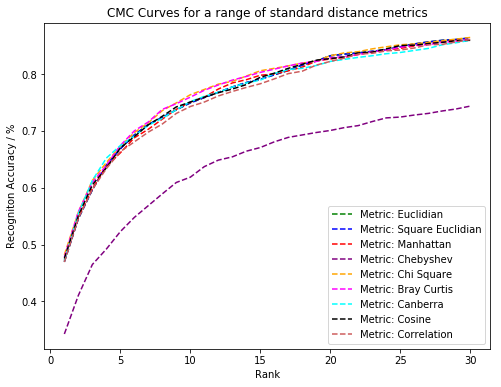

In [24]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(metric_l)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='Metric: '+ metric_l[i])

plt.title('CMC Curves for a range of standard distance metrics')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

In [1]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(metric_l)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='Metric: '+ metric_l[i])

plt.title('CMC Curves for a range of standard distance metrics')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

NameError: name 'plt' is not defined